# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ ~~2 次のトロッターにしてみる~~
+ ~~GHZ を中心に寄せる。このままだと不要な Trotter gate があるので。~~
+ 不要な interaction を削除

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

In [5]:
# Option1: Use IBM Quantum backend.
# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'cz', 'id', 'measure', 'reset', 'sx']>)


# データセット作成 $\exp(-\beta H)$

In [6]:
n_samples = 70
n_qubits = 10
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

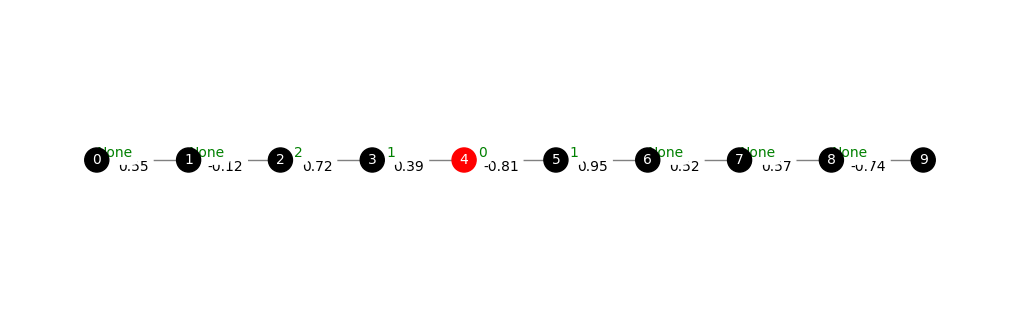

In [7]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [8]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 0011111000
decimal: 248
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [9]:
data = []
graphs = []
# For debugging
# eigvals_abs_max = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    # H = H.to_matrix(sparse=True)

    # state is big endian, so we need to reverse the qubits of the Hamiltonian
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)
    norm = scipy.sparse.linalg.norm(H, ord=2)

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y, "norm": norm})
    graphs.append(G)

    # For debugging
    # eigvals_abs_max.append(max(np.abs(scipy.linalg.eigvals(H.toarray()))))

df = pd.DataFrame(data)
df

Sample 0/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00107791]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 18 instead with accuracy 
0.0010193052048841622.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00101931]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('

Sample 1/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00181111]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0018111146349086694.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00181111]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 2/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[8.43736152e-05]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
8.437361519304236e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[8.43736152e-05]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 3/70
Sample 4/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.25361834]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.2536183432773276.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.25361834]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 5/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.04483104]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.04483104357883747.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.04483104]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 6/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00455101]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.004551013764236384.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00455101]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 7/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02434927]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.024349269636967437.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02434927]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 8/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00258589]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 19 instead with accuracy 
0.0020105553651839766.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00201056]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 9/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00816048]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 13 instead with accuracy 
0.0029517672384422383.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00295177]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 10/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00061182]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0006118163000883784.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00061182]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 11/70
Sample 12/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00769415]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.007694149291504889.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00769415]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 13/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0024504]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.002450397023331709.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0024504]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 14/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0039157]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 20 instead with accuracy 
0.0025693638623558884.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00256936]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 15/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.13838109]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 12 instead with accuracy 
0.07125087341671031.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.07125087]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 16/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.05569997]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.05569996685022678.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.05569997]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 17/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.05323534]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.05323534045558343.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.05323534]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 18/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.29437658]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.29437658432566977.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.29437658]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 19/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.07072507]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0707250666237176.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.07072507]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 20/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01699119]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 20 instead with accuracy 
0.016700400971019814.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0167004]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 21/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01719998]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0171999759142536.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01719998]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 22/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00154156]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 19 instead with accuracy 
0.0002936620191239768.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00029366]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 23/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01332935]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 18 instead with accuracy 
0.003205340224781511.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00320534]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 24/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.24121729]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.24121729238471756.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.24121729]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 25/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0966212]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0966212004809833.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0966212]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 26/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.07855813]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 19 instead with accuracy 
0.038267119796935846.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.03826712]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 27/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00220315]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.002203150444068435.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00220315]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 28/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00975305]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 20 instead with accuracy 
0.00969035440597412.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00969035]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 29/70
Sample 30/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00876071]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.008760712941866424.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00876071]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 31/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00415403]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 20 instead with accuracy 
0.00404137915392538.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00404138]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 32/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00899475]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.008994754103593005.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00899475]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 33/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02013941]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 18 instead with accuracy 
0.009700992518264017.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00970099]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 34/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0008813]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 19 instead with accuracy 
0.0006060527043827949.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00060605]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 35/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.35502362]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 16 instead with accuracy 
0.17943386296374317.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.17943386]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 36/70
Sample 37/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02803662]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.028036616523298266.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02803662]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 38/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00021025]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0002102530218104491.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00021025]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 39/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00273042]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0027304204486105366.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00273042]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 40/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01750522]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.01750522336800593.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01750522]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 41/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.05297354]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 19 instead with accuracy 
0.037018822829926246.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.03701882]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 42/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.10714406]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.10714405724635016.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.10714406]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 43/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02171169]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.021711692866740743.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02171169]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 44/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02011695]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 20 instead with accuracy 
0.017242146010369334.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01724215]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 45/70
Sample 46/70
Sample 47/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.000214]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.00021399996113672192.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.000214]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 48/70
Sample 49/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0061683]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.006168303630314139.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0061683]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 50/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00119648]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0011964836678189125.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00119648]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 51/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00016929]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.00016928698045660842.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00016929]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 52/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00011207]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.00011206883146737116.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00011207]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 53/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00038395]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0003839484405857121.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00038395]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 54/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00066592]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0006659165140560296.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00066592]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 55/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.08026336]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 14 instead with accuracy 
0.0038800279566016307.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00388003]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 56/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.3017198]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 15 instead with accuracy 
0.07247197554019845.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.07247198]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 57/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00077243]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.0007724327581269635.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00077243]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 58/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.08228509]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.08228509319006215.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.08228509]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 59/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0466818]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.04668180470806452.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0466818]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 60/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00367472]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.003674717186498963.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00367472]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 61/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01387141]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.013871412088423418.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01387141]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 62/70
Sample 63/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.06662464]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 20 instead with accuracy 
0.036774509426159833.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.03677451]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 64/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00652825]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 12 instead with accuracy 
0.006243015873115447.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00624302]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 65/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.002969]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.002969000208935121.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.002969]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 66/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.26619955]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 19 instead with accuracy 
0.21481354372081848.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.21481354]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 67/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00337775]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.003377750889742902.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00337775]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 68/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00285642]
not reaching the requested tolerance 1.52587890625e-05.
Use iteration 21 instead with accuracy 
0.00285642428864217.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00285642]
not reaching the requested tolerance 1.52587890625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 69/70


,Js,expected_value,norm
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",1.582990,9.580142
1,"[-0.09922812420886573, -0.25840395153483753, 0...",0.453302,6.686238
2,"[0.6552623439851641, 0.2633287982441297, 0.516...",1.100555,8.876921
3,"[-0.9123924684255424, -0.6914210158649043, 0.3...",1.057326,7.928723
4,"[-0.7401569893290567, -0.04859014754813251, -0...",2.430337,6.746732
...,...,...,...
65,"[0.2616644807294848, -0.644986835126065, -0.32...",2.544589,7.228165
66,"[-0.9853710874139687, -0.44395578679837233, 0....",0.095130,8.179614
67,"[0.44139189343670315, 0.9264224470987592, 0.56...",2.769300,8.050436
68,"[0.9396302334111388, 0.9691561628632492, -0.42...",6.544680,9.139168


## Pre-process data

In [10]:
df["expected_value"].describe()

count     70.000000
mean      10.600651
std       34.164733
min        0.095130
25%        1.375474
50%        2.757324
75%        9.339521
max      283.573595
Name: expected_value, dtype: float64

In [11]:
# Query the 80% quantile
q = df["expected_value"].quantile(0.8)
filtered_index = df.query(f"expected_value < @q").index
diffrence = df.index.difference(filtered_index)
print(f"Outliers: {diffrence}")

# Remove outliers
df = df.drop(diffrence).reset_index(drop=True)
graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([6, 9, 10, 12, 16, 19, 26, 37, 43, 46, 48, 50, 52, 57], dtype='int64')


In [12]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value,norm
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",1.582990,9.580142
1,"[-0.09922812420886573, -0.25840395153483753, 0...",0.453302,6.686238
2,"[0.6552623439851641, 0.2633287982441297, 0.516...",1.100555,8.876921
3,"[-0.9123924684255424, -0.6914210158649043, 0.3...",1.057326,7.928723
4,"[-0.7401569893290567, -0.04859014754813251, -0...",2.430337,6.746732
5,"[0.6095287149936037, -0.22504324193965108, -0....",1.390452,7.885196
6,"[0.5299977148320512, 0.2694366400011816, 0.107...",5.624548,5.765879
7,"[0.7068061465363322, -0.5321210282693185, -0.8...",1.090109,6.703631
8,"[0.9237953290990291, 0.8171613814152141, 0.399...",8.392081,9.360458
9,"[0.4389259119018736, -0.13581392044979257, 0.2...",1.481529,6.447180


Number of samples: 56


count    56.000000
mean      3.382580
std       3.210914
min       0.095130
25%       1.081913
50%       2.314193
75%       5.423226
max      11.765608
Name: expected_value, dtype: float64

In [13]:
df["norm"].describe()

count    56.000000
mean      7.728077
std       1.460874
min       4.149999
25%       6.735957
50%       7.801931
75%       8.505239
max      11.274471
Name: norm, dtype: float64

## Check eigvals and Configure params

In [14]:
n_features = 10  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
# C = 10 * n_qubits  # upper bound for eigenvalues
C = max(df["norm"])
times = [np.pi * k / C for k in range(n_features)]

print(f"C: {C}")
print(f"times: {times}")

C: 11.27447148961441
times: [0.0, 0.27864655620298495, 0.5572931124059699, 0.8359396686089549, 1.1145862248119398, 1.3932327810149248, 1.6718793372179097, 1.9505258934208947, 2.2291724496238796, 2.507819005826865]


In [15]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [16]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-10T15:41Z
Saving data to ./data/2024-12-10T15:41Z


In [17]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
        indent=4,
    )